In [1]:
import os
import sys
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from scoring import bc_scoring, bc_score_names

In [2]:
# parameters
save_path = "model/save/b_v0_0_2022-10-20_09-08"
#save_path = "model/save/b_v0_1_2022-10-20_09-29"

dataset_path = "datasets/100mV_0-90rI_bg-ps"

In [10]:
# add module to path
if save_path not in sys.path:
    sys.path.insert(0, save_path)
    
# load functions
from config import config_data, config_model
from data_handler import Dataset
from model import Model

In [4]:
# load data
f = np.load(os.path.join(dataset_path, "test_dataset.npz"), allow_pickle=True)
dataset = Dataset(list(f['X']), list(f['y']))

print(len(dataset))

17090


In [5]:
# device
device = pt.device("cuda")

# create model
model = Model(config_model).to(device)

# reload model
model.load_state_dict(pt.load(os.path.join(save_path, "model.pt"), map_location=pt.device("cpu")))

# set model to inference
model = model.eval().to(device)

In [6]:
results = []
with pt.no_grad():
    for X,y in tqdm(dataset):
        z = model.forward(X.to(device))
        p = pt.softmax(z.detach(), axis=1)
        t = np.argmax(p.cpu().numpy(), axis=1)
        results.append([p.cpu().numpy(), t, y.cpu().numpy()])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17090/17090 [00:18<00:00, 917.16it/s]


In [7]:
# pack results
p = np.concatenate([r[0] for r in results])
t = np.concatenate([r[1] for r in results])
y = np.concatenate([r[2] for r in results])

# compute scores
scores = bc_scoring(pt.from_numpy(y).unsqueeze(1), pt.from_numpy(p[:,1]).unsqueeze(1)).flatten().cpu().numpy()
dfs = pd.Series({sn:s.item() for sn,s in zip(bc_score_names, scores)})

dfs.round(2)

acc    0.80
ppv    0.80
npv    0.81
tpr    0.80
tnr    0.81
mcc    0.61
auc    0.87
std    0.29
dtype: float64

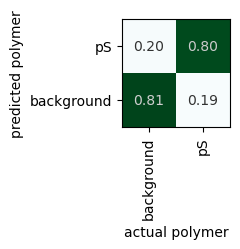

In [8]:
# parameters
labels = ['background', 'pS']
cutoff_perc = 0.1

# confusion matrix
n = p.shape[1]
C = np.zeros((n,n), dtype=int)

for i in np.unique(y):
    for j in np.unique(y):
        C[i,j] = np.sum((y == i) & (t == j))
        
C = C / np.sum(C, axis=0).reshape(-1,1)

# plot
plt.figure(figsize=(2.5,2.5))
plt.imshow(C, cmap="BuGn", origin='lower')
for ipl in range(C.shape[1]):
    for itl in range(C.shape[0]):
        if C[itl, ipl] > cutoff_perc:
            plt.text(ipl, itl, "{:.2f}".format(C[itl, ipl]), va='center', ha='center', color=[C[ipl, itl]]*3)
plt.xticks(list(range(len(labels))), labels, rotation=90)
plt.yticks(list(range(len(labels))), labels, rotation=0)
plt.xlabel('actual polymer')
plt.ylabel('predicted polymer')
plt.tight_layout()
plt.savefig("graphs/confusion_matrix.png", dpi=200)
plt.savefig("graphs/confusion_matrix.pdf")
plt.show()

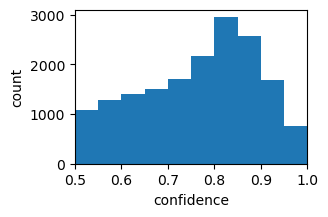

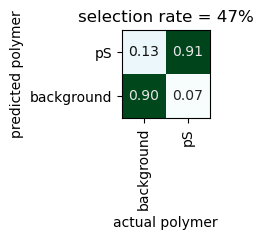

In [9]:
# parameters
labels = ['background', 'pS']
cutoff_perc = 0.05
c_thr = 0.8

# confidence
c = np.maximum(p[:,0], 1.0-p[:,0])
mc = (c > c_thr)

# confusion matrix
n = p.shape[1]
C = np.zeros((n,n), dtype=int)

for i in np.unique(y):
    for j in np.unique(y):
        C[i,j] = np.sum((y[mc] == i) & (t[mc] == j))
        
C = C / np.sum(C, axis=0).reshape(-1,1)

# plot
plt.figure(figsize=(3,2))
plt.hist(c, bins=10, range=(0.5,1.0))
plt.xlim(0.5, 1.0)
plt.xlabel("confidence")
plt.ylabel("count")
plt.show()

# plot
plt.figure(figsize=(2.5,2.5))
plt.imshow(C, cmap="BuGn", origin='lower')
for ipl in range(C.shape[1]):
    for itl in range(C.shape[0]):
        if C[itl, ipl] > cutoff_perc:
            plt.text(ipl, itl, "{:.2f}".format(C[itl, ipl]), va='center', ha='center', color=[C[ipl, itl]]*3)
plt.xticks(list(range(len(labels))), labels, rotation=90)
plt.yticks(list(range(len(labels))), labels, rotation=0)
plt.xlabel('actual polymer')
plt.ylabel('predicted polymer')
plt.title('selection rate = {:.0f}%'.format(np.mean(mc)*1e2))
plt.tight_layout()
plt.savefig("graphs/confusion_matrix_sel.png", dpi=200)
plt.savefig("graphs/confusion_matrix_sel.pdf")
plt.show()